---
# <div style="text-align: center;"> Assignment 2 </div>

<div style="text-align: center;">
Name: Jiahui Bai (3735049)
</div>

<div style="text-align: center;">
Name: Dewei Ning (3962963)
</div>

---

Import the necessary dependent libraries

If you can't import the imgaug library.
Please use the following command to install.
```
pip install git+https://github.com/marcown/imgaug.git
```


Due to the current open issue in the TensorFlow framework ([GitHub issue #59779](https://github.com/tensorflow/tensorflow/issues/59779)), the following message may appear during training:

```
I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting
(this does not indicate an error and you can ignore this message):
INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0'
with dtype int32 [[{{node Placeholder/_0}}]]
```

To suppress this unnecessary message, we can use the following code to set the environment variable and set the TensorFlow log level to 2:

```python
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
```

This will reduce or suppress the output of these messages. Please note that these messages are only debug information and do not indicate an error. You can safely ignore them.


It is normal to encounter the following warning:

```
WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
```
Since we were using an M1 Mac for this task, the warning recommends falling back to legacy Keras optimizers, specifically `tf.keras.optimizers.legacy.Adam`, to alleviate performance issues.

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import math
import random
import matplotlib.image as mpimg
from PIL import Image
from scipy.stats import ks_2samp
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Get the dataset as a dataframe

In [95]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

# EDA
## Dataset foundation information
This is a dataset that contains 9,896 entries, and each entry has six fields. These fields include 'InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType', and 'isCancerous'. Among these fields, four are of integer type (int64), and two are of object type, which means they are strings or other non-numerical types of data.

From the data types, we can understand that this dataset primarily includes the following information:

1. **InstanceID**: This is a unique identifier for each entry, typically used to uniquely identify each sample.
2. **patientID**: This is a unique identifier for each patient.
3. **ImageName**: This is the file name or path of each cell image.
4. **cellTypeName**: This is the name of the cell type.
5. **cellType**: This is the numerical encoding of the cell type.
6. **isCancerous**: This is a boolean value indicating whether the cell is cancerous or not.

There are no missing values in any of the fields in the dataset, which means we can directly use this dataset for further data analysis and model training without handling missing values.

### Task definition
Based on the data information and task requirements, the goal is to perform image classification for cancer and cell categories using the given dataset. Therefore, this is a supervised learning problem, which involves both binary classification for cancerous and non-cancerous cells and multi-class classification for different cell types.

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


## Check image details
From the following results, we can observe that the dataset consists of 9,896 cell images. The image size is 27x27, and since the standard deviation of the image sizes is 0, it means that all the images in the dataset are 27x27 pixels, indicating that they have the same dimensions. This is highly advantageous for our image classification task as it eliminates the need for resizing the images. Having images with the same size allows us to directly input them into the neural network model without any additional preprocessing steps. This not only saves a significant amount of preprocessing time but also reduces the potential introduction of errors. Furthermore, having consistent image sizes ensures that our model performs consistently across the entire dataset, improving the stability and reliability of the model.

In [97]:
# calculate the length of the dataset.
dataset_size = len(data)
# Save the all the image's file names into 'image_files'
image_files = data['ImageName'].values
# Calculate all the types of cells
num_classes = data['cellTypeName'].nunique()
#Calculate all the patients number
num_patients = data['patientID'].nunique()
# Get the size of the images
image_sizes = []
for image_file in image_files:
    image = Image.open("./Image_classification_data/patch_images/" + image_file)
    image_sizes.append(image.size)
# Calculate the mean and standard deviation of the image size
mean_image_size = np.mean(image_sizes, axis=0)
std_image_size = np.std(image_sizes, axis=0)
# Print output
print(f"Dataset Size: {dataset_size}")
print(f"Number of Categories: {num_classes}")
print(f"Number of Patients: {num_patients}")
print(f"Image Size Mean: {mean_image_size}")
print(f"Image Size Standard Deviation: {std_image_size}")

Dataset Size: 9896
Number of Categories: 4
Number of Patients: 60
Image Size Mean: [27. 27.]
Image Size Standard Deviation: [0. 0.]


## Duplicate Sample Detection
We can use the following code to check if there are any duplicate images in the dataset, i.e., cases where one image corresponds to multiple patients. This can have implications for our data analysis and the construction and training of our model because ideally, we want each image in the data to correspond to a unique patient to avoid data confusion or errors. If such duplicate images exist, we may need to further investigate and determine how to handle this data.

In [98]:
# Calculate how many patients does the image belong to.
grouped = data.groupby(['ImageName', 'patientID']).size().reset_index(name='counts')

# Find 'ImageName' with 'counts' larger than 1
duplicated_images = grouped[grouped.duplicated('ImageName', keep=False)]['ImageName'].unique()

# print output
if len(duplicated_images) > 0:
    print("Here is the image which has different patients with it：")
    for image in duplicated_images:
        print(image)
else:
    print("There is no image corresponding to multiple patients.")

There is no image corresponding to multiple patients.


## Distribution of Cell Types for Each Patient
We utilized the following code to display the counts of different cell types (`cellTypeName`) for each patient (`patientID`). By observing this graph, we can see that the distribution of cell types varies among patients. Certain cell types are more common in some patients while less frequent in others. Additionally, we can observe variations in the number of samples for each patient, indicating an imbalance in the dataset across patients. This imbalance may affect the performance of our model. Therefore, before proceeding with model training, it may be necessary to consider appropriate data balancing techniques. It's important to note that due to significant distribution differences between patients, dividing the dataset based on patient IDs can result in substantial distribution bias between the training and testing sets. This can impact the model's performance and lead to inaccurate performance evaluations.

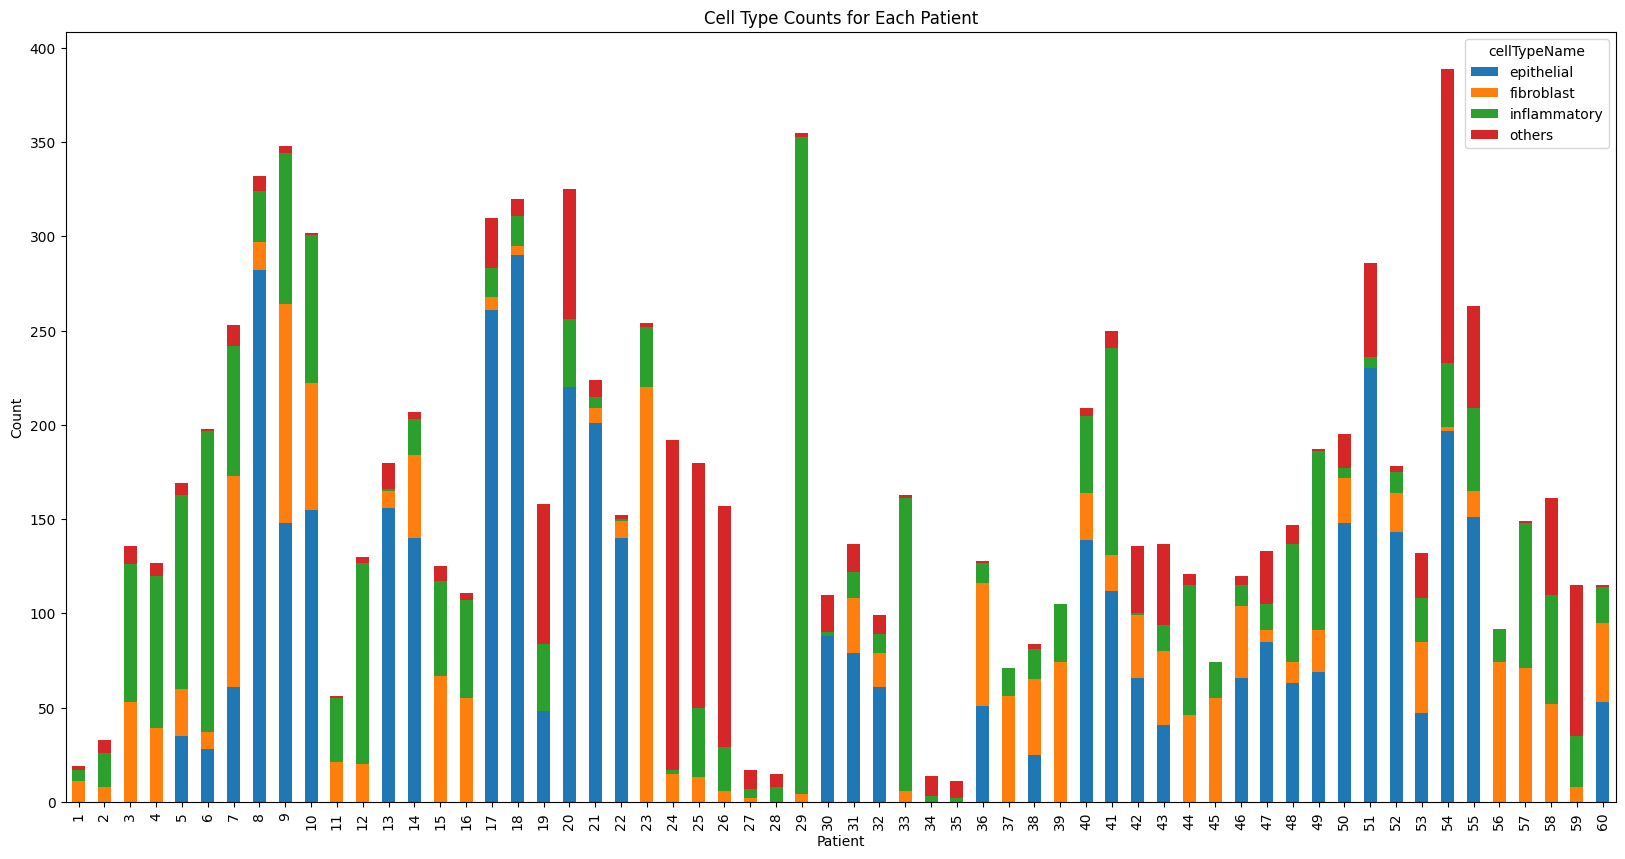

In [99]:
# Get sort counts based on 'patientID' and 'cellTypeName' grouping.
grouped_df = data.groupby(['patientID', 'cellTypeName']).size().reset_index(name='counts')

# Converting data to a form suitable for graphing
pivot_df = grouped_df.pivot(index='patientID', columns='cellTypeName', values='counts')
pivot_df = pivot_df.fillna(0)

# creat stacked bar graph
pivot_df.plot(kind='bar', stacked=True, figsize=(20,10))

# set title and label for X and Y
plt.title('Cell Type Counts for Each Patient')
plt.ylabel('Count')
plt.xlabel('Patient')

# show the graph
plt.show()

## Data Distribution
From the following graph, we can observe that the distribution of samples labeled as non-cancerous and cancerous in the `isCancerous` field is not uniform, indicating a significant class imbalance in the data. Similarly, the distribution of different cell types in the `cellType` field also exhibits class imbalance. This imbalanced data distribution can have an impact on model training, such as causing the model to be biased towards predicting the majority class, thereby affecting the model's performance on the minority class predictions. Due to the presence of significant data imbalance, we will address this issue by assigning weights to mitigate the effect of the imbalanced dataset.

Additionally, we will not consider patient-related factors when partitioning the dataset. Instead, we will ensure that the training, testing, and validation sets maintain the same distribution as the overall dataset.

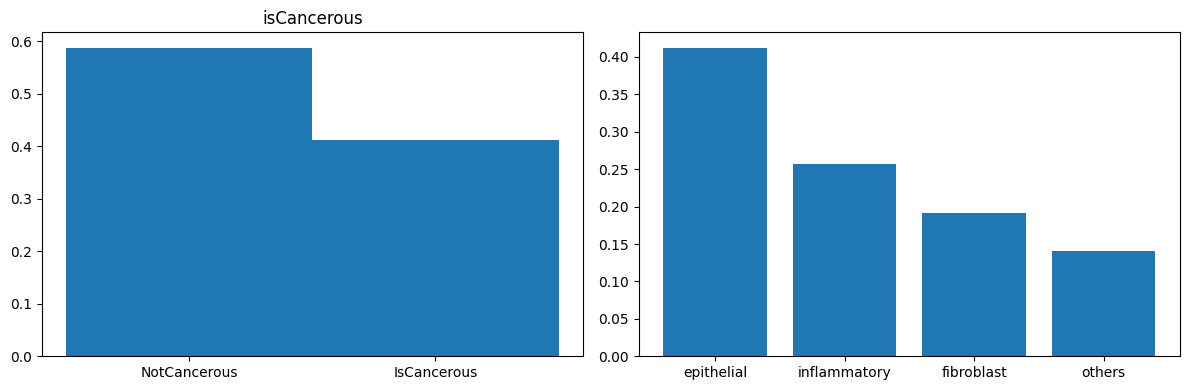

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
weights = np.ones_like(data['isCancerous']) / len(data['isCancerous'])
value_counts = data['cellTypeName'].value_counts(normalize=True)
axs[0].hist(data['isCancerous'], weights=weights, bins=np.array([-0.5, 0.5, 1.5]))
axs[0].set_xticks([0, 1], ['NotCancerous', 'IsCancerous'])
axs[0].set_title('isCancerous')
axs[1].bar(value_counts.index, value_counts.values)
plt.tight_layout()
plt.show()


## Relationship between cell types and cancer cells
From the table below, we can observe that all cell types labeled as 'epithelial' are diagnosed as cancerous. This may indicate a higher risk of cancer occurrence associated with the 'epithelial' cell category. On the other hand, other cell categories such as 'fibroblast', 'inflammatory', and 'others' are not diagnosed as cancerous in our dataset. However, it is important to note that we cannot simply classify 'epithelial' cells as cancerous and consider all other cell types as non-cancerous. This is because we cannot guarantee the absence of cancer cases among cell types other than 'epithelial' in extra datasets.

In [101]:
cancer_counts = data.groupby('cellTypeName')['isCancerous'].value_counts().unstack()
cancer_counts.fillna(0, inplace=True)
print(cancer_counts)

isCancerous        0       1
cellTypeName                
epithelial       0.0  4079.0
fibroblast    1888.0     0.0
inflammatory  2543.0     0.0
others        1386.0     0.0


## Cell sample display

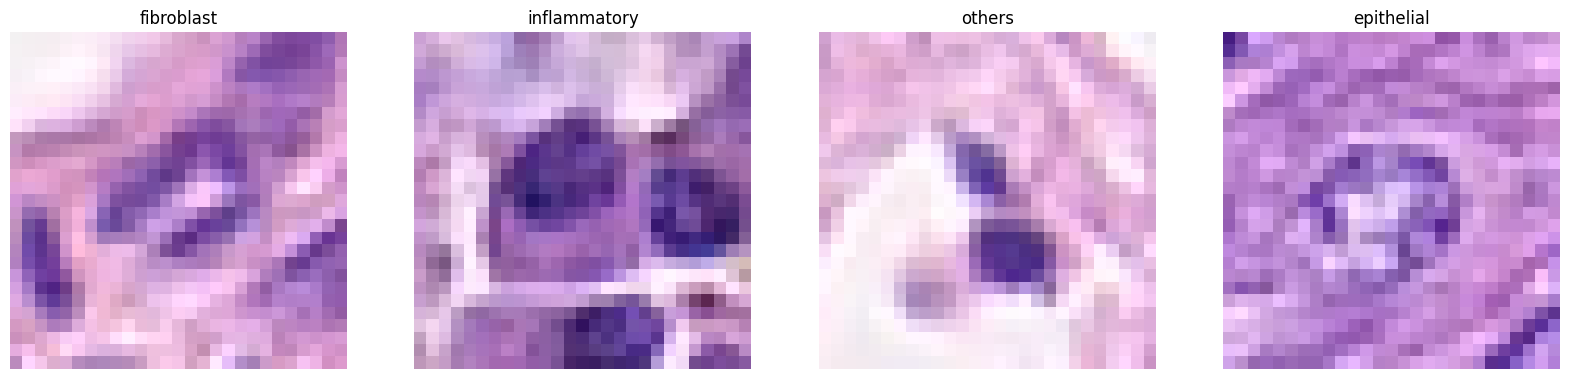

In [102]:
unique_cell_types = data['cellTypeName'].unique()
selected_images = {}

for cell_type in unique_cell_types:
    images_of_cell_type = data[data['cellTypeName'] == cell_type]
    selected_image = images_of_cell_type.sample(n=1).iloc[0]
    selected_images[cell_type] = selected_image['ImageName']

fig, axes = plt.subplots(1, len(unique_cell_types), figsize=(len(unique_cell_types) * 5, 5))

for ax, (cell_type, image_path) in zip(axes, selected_images.items()):
    img = mpimg.imread("./Image_classification_data/patch_images/" + image_path)
    ax.imshow(img)
    ax.set_title(cell_type)
    ax.axis('off')

plt.show()

## Visualization of Image Enhancement
The images below illustrate the differences between the visual effects of image enhancement before and after the process. This visualization helps us better understand the practical impact of enhancement methods on the images. By examining these visualizations, we can determine whether any undesired side effects may arise and assess whether the enhancements provide sufficient variations to enhance the model's generalization ability.

In [103]:
def visualize_augmentation(image, generator, num_augmented_images=5):
    # Convert the PIL.Image object to a NumPy array, and expand the dimensions to fit the ImageDataGenerator
    image_array = np.expand_dims(np.array(image), axis=0)

    # Generate augmented images using ImageDataGenerator
    augmented_images = generator.flow(image_array, batch_size=1)

    # Draw the original image and the augmented image
    fig, axes = plt.subplots(1, num_augmented_images + 1, figsize=(15, 15))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for ax, aug_image in zip(axes[1:], augmented_images):
        ax.imshow(aug_image[0].astype(np.uint8))
        ax.set_title("Augmented Image")
        ax.axis("off")

        num_augmented_images -= 1
        if num_augmented_images == 0:
            break

    plt.show()

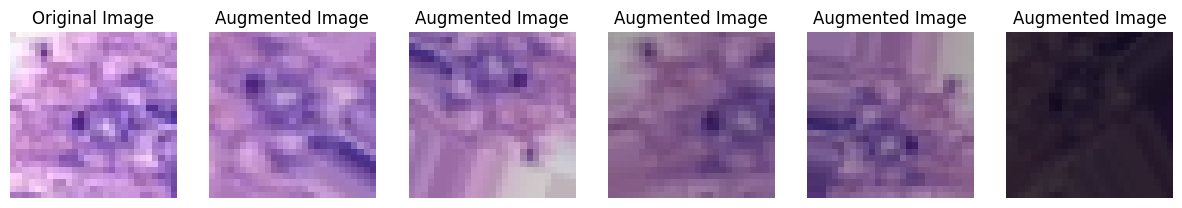

In [104]:
# Randomly choose an image
selected_image = data.sample(n=1).iloc[0]['ImageName']
image = Image.open("./Image_classification_data/patch_images/" + selected_image)
# Create ImageDataGenerator object
augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
# 可视化图像增强效果
visualize_augmentation(image, augmentation_generator)

---
# Data Split
## Training, Validation, and Testing Sets
In this project, I have used a training set, a validation set, and a testing set. First, I split 80% of the data into the training set and validation set, while the remaining 20% is allocated as an unseen testing set. This division ensures that the model has sufficient data for learning during the training process, enhancing its accuracy and robustness while preventing underfitting. Additionally, the 20% unseen testing data serves as an independent dataset to evaluate the final performance of the model. It helps assess the model's generalization ability on unseen data rather than just measuring its fit on the training data.

Next, I further divide the training set and validation set, allocating 80% for the training set and 20% for the validation set. The training set is used to train the model, while the validation set plays a crucial role in assessing the model's performance on each epoch. It helps identify whether the model is overfitting or underfitting. Additionally, we can dynamically adjust the learning rate based on changes in the validation set loss.

In [105]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
ia.seed(seed_value)

data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

### Distribution Testing for Data Split
It is essential to ensure that the training and testing sets have similar distributions to ensure that the trained model exhibits good generalization on the testing set. If the distributions are dissimilar, the testing set may not represent the training set, and the performance metrics obtained on the testing set may not accurately reflect the model's performance in real-world applications. This could lead to a misjudgment of the model's performance. To evaluate the similarity of distributions between the training and testing sets, I have conducted the Kolmogorov-Smirnov (KS) test. This test compares each column of the training and testing sets to assess the similarity of their distributions. The null hypothesis states that each column of the training and testing sets follows the same distribution. If the p-value is less than the chosen significance level (0.05), we can reject the null hypothesis, indicating a significant difference in the distributions. Similarly, examining the distributions of the training set and the undivided dataset is also important. This helps ensure that the training set represents the undivided dataset and aids in identifying any biases between the training set and the undivided dataset. Therefore, I have also conducted KS tests between the training set and the undivided dataset.

In [106]:
def is_same_distribution(datasets_a, datasets_b):
    alpha = 0.05
    p_value_map = dict()
    for column in datasets_a.columns:
        _, p_value = ks_2samp(datasets_a[column], datasets_b[column])
        p_value_map[column] = p_value

    columns_with_p_value_less_than_005 = []
    for column, p_value in p_value_map.items():
        if p_value < alpha:
            columns_with_p_value_less_than_005.append(column)
    return len(columns_with_p_value_less_than_005) == 0, columns_with_p_value_less_than_005

# Make sure the distribution of the training set and the test set are the same
is_same, diff_columns = is_same_distribution(train_data, test_data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the test set.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

# Make sure the distribution of the training set and the test set are the same
is_same, diff_columns = is_same_distribution(train_data, val_data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the validation set.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

# Make sure the distribution of the training set and the overall dataset are the same
is_same, diff_columns = is_same_distribution(train_data, data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the entire dataset.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

The null hypothesis is accepted for the distribution of both the train set and the test set.
The null hypothesis is accepted for the distribution of both the train set and the validation set.
The null hypothesis is accepted for the distribution of both the train set and the entire dataset.


### Histograms showing the data distribution
From the graph below, we can observe that the data distributions of the training, validation, and testing sets are similar. This helps ensure that the model performs consistently across these datasets and exhibits good generalization ability. When the training, validation, and testing data have similar distributions, the model is more likely to validate the patterns learned from the training set on the validation and testing sets, thereby improving its predictive performance on unknown data. This also enables us to evaluate the model's performance more accurately, avoiding performance discrepancies caused by inconsistent data distributions.

Text(0.5, 1.0, 'cellType')

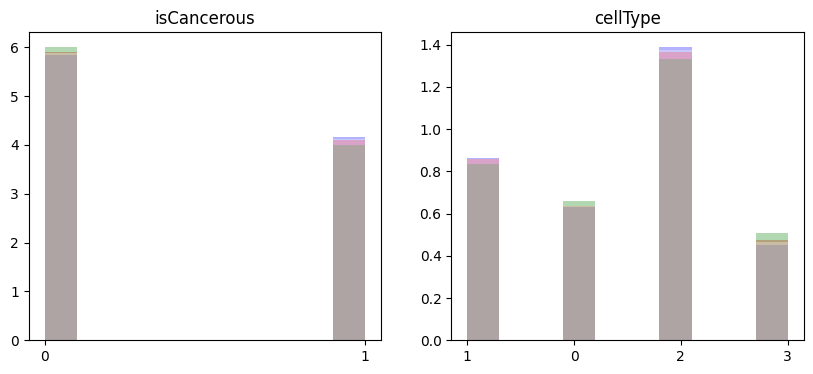

In [107]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
axes[0].hist(val_data['isCancerous'], alpha=0.3, color='r', label='validation', density=True)
axes[0].hist(test_data['isCancerous'], alpha=0.3, color='g', label='Test', density=True)
axes[0].hist(data['isCancerous'], alpha=0.3, color='w', label='overall',  density=True)
axes[0].set_title('isCancerous')
axes[1].hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
axes[1].hist(val_data['cellType'], alpha=0.3, color='r', label='validation', density=True)
axes[1].hist(test_data['cellType'], alpha=0.3, color='g',label='Test', density=True)
axes[1].hist(data['cellType'], alpha=0.3, color='w', label='overall',  density=True)
axes[1].set_title('cellType')

### Leakage test
In addition, it is crucial to guarantee a clear demarcation between the training and testing datasets. Having overlapping samples can lead to data leakage, where the model inadvertently gains access to information from the testing set while being trained. Data leakage can cause the model to excessively adapt to specific data in the testing set, generating a deceptively outstanding performance on the testing set. Nevertheless, this excessively optimistic performance may not truly represent the model's capability to handle unfamiliar real-world data, consequently leading to subpar performance in practical scenarios.

In [108]:
combined_df = pd.concat([train_data, test_data], axis=0, ignore_index=True)
duplicated_rows = combined_df.duplicated()
if duplicated_rows.any():
    print("The training set and the test set have the same instances: ", combined_df[duplicated_rows])
else:
    print("The training set and the test set do not have the same instances")

The training set and the test set do not have the same instances


---
# Assigning Class Weights
As mentioned earlier, due to the imbalance in the distribution of classes, we will add weights in the subsequent improved model to mitigate the impact of imbalanced data. For the baseline model, we will not use class weights because we want to observe the original performance of the model without class weights. We will then evaluate the performance improvement in the enhanced model by adding class weights.

In [109]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

---
# Summary of Hyperparameters

In this section, I will summarize all the hyperparameters required for this task. First, we have the hyperparameters that are common to all neural networks:

1. **Learning Rate**: The learning rate determines the speed at which the model updates the weights during optimization. A high learning rate may cause the model to oscillate around the optimal solution without converging, while a low learning rate may result in slow training or premature convergence.

2. **Batch Size**: The batch size represents the number of samples used for weight updates in each training iteration. It affects both training speed and model performance. Larger batch sizes may lead to faster training but could be susceptible to local optima, while smaller batch sizes allow the model to explore the parameter space better but may slow down training.

3. **Number of Neurons**: The number of neurons in each hidden layer affects the model's complexity. Too many neurons can lead to overfitting, where the model performs well on the training data but poorly on unknown data, while too few neurons may prevent the model from learning complex patterns in the data.

4. **Number of Hidden Layers**: The number of hidden layers also influences the model's complexity. Too many hidden layers can lead to overfitting, while too few hidden layers may prevent the model from learning complex patterns in the data.

5. **Activation Function**: The activation function determines the output and gradient updates of the neurons. Different activation functions have different characteristics. For example, the ReLU activation function can alleviate the vanishing gradient problem, while Sigmoid and Tanh may be more suitable in certain cases.

6. **Regularization Techniques**: Regularization techniques such as L1/L2 regularization and dropout can help prevent overfitting. Different regularization techniques, combinations, and their regularization strengths can be chosen.

7. **Optimizer**: The optimizer determines how the model's parameters are updated during training. Its main task is to minimize the loss function by adjusting the model's weights. Common optimizers include SGD (Stochastic Gradient Descent), RMSprop, Adam, etc.

8. **Number of Training Epochs**: Each training epoch represents one complete pass of the model over all the training samples. Too few epochs may result in underfitting on the training set, while too many epochs may lead to overfitting, where the model performs well on the training set but poorly on the testing set or new data.

Next, for CNNs, we have some additional key hyperparameters:

1. **Kernel Size**: The kernel size in convolutional layers determines the scale of spatial patterns the model can capture. Larger kernel sizes can capture larger-scale patterns but may overlook finer details, while smaller kernel sizes can capture finer patterns but may miss larger-scale structures.

2. **Number of Convolutional Layers and Filter Count**: These parameters affect the model's depth, width, and the number of different types of features the model can capture.

3. **Pooling Layer**: Pooling layers are used to reduce the dimensions of features and extract prominent features. They help reduce computation and the number of parameters in the model, thus alleviating overfitting.

4. **Stride**: The stride determines the distance by which the convolutional kernel moves on the input feature map. A larger stride can reduce the output feature map's size, thus decreasing computation, but it may result in the loss of some information.

5. **Padding**: Padding is used to maintain the spatial dimensions of the feature maps during convolutional operations. It helps the model better learn the boundaries of images.

Finally, there are additional hyperparameters specific to this task:

1. **Consistency Loss Weight**: In this task, during the FixMatch process, a consistency loss is computed for weak and strong augmented images. This hyperparameter controls the strength of the consistency loss, similar to regularization strength.

2. **Probability Threshold**: In the FixMatch algorithm, the probability threshold is a critical hyperparameter. If the predicted probability exceeds the threshold, the prediction is considered confident and used as pseudo-labels for updating the model. Setting the threshold too low may introduce a large number of erroneous pseudo-labels, leading to the model training in the wrong direction. Conversely, setting the threshold too high may result in the majority of unlabeled data not being effectively utilized.

3. **Number of Image Augmentation Techniques**: In this task, controlling the number of image augmentation techniques helps enhance the diversity of training samples and improve the model's generalization ability and robustness.

4. **Learning Rate Reduction Factor**: This hyperparameter determines the extent to which the current learning rate should be reduced when there is no improvement in the validation loss. The setting of this factor directly affects the speed and stability of model convergence.

5. **Patience**: In the learning rate scheduler, patience is a critical hyperparameter that determines how many epochs to wait when there is no improvement in the validation loss before reducing the learning rate.

6. **Minimum Learning Rate**: This hyperparameter sets the lower limit for the learning rate, preventing it from becoming too small and causing the model training to stagnate.

By tuning these hyperparameters, we can optimize the model's performance and ensure that it learns the underlying patterns in the data effectively.

---
# Data Generator for the Baseline Model

The code snippet below prepares the data generator for our baseline model. The data generator is used to batch-load and preprocess images, making them ready for training, validation, and testing the model. Additionally, the data generators for the validation and testing sets will also be used for the improved model, as they don't require additional image augmentation.

We utilize the `ImageDataGenerator` class from Keras, which allows efficient loading of images from disk and applies real-time data augmentation. However, in this case, we only rescale the pixel values of the images from the range [0, 255] to the range [0, 1]. This normalization helps improve the performance and stability of the neural network. Similarly, for the unseen testing and validation sets, image normalization is also applied. This is because the testing set is used to evaluate the model's performance and, like the training and validation sets, requires the same preprocessing methods to ensure accuracy and comparability of the test results. As for the batch size, it is a hyperparameter we can adjust, and we set it as 32 for our final size. We also experimented with other hyperparameters, and while larger batch sizes resulted in faster training, there was a decrease in model performance. Smaller batch sizes did not yield better model performance either. Meanwhile, to maintain consistency among the training, validation, and testing sets, we also set the batch size for the validation and testing sets as 32.

Next, we use the `flow_from_dataframe` method of the `ImageDataGenerator` to read the images directly from the specified directory, which in this case is `./Image_classification_data/patch_images`. It uses the previously created data frame to obtain the image file names (from the `ImageName` column) and their respective labels (from the `isCancerous` and `cellType` columns).

The `class_mode` parameter in the `flow_from_dataframe` method is set to `binary` when reading the `isCancerous` label and `categorical` when reading the `cellType` label, as `isCancerous` is a binary classification task while `cellType` is a multi-class classification task. It is important to note that the `categorical` mode automatically one-hot encodes the labels, which is necessary for multi-class classification tasks. And to ensure the effectiveness of our evaluation of the model, I set `shuffle` to `False`. This is because when we use the `predict` method of the model and `shuffle` is set to `True`, the `predict` method internally shuffles the data, making it impossible for us to correctly match the correct labels with the trained samples.

The training data generators `train_isCancerous_generator` and `train_cellType_generator` are specifically created for the baseline model. Later, we will create new data generators for the improved model, where we will apply more advanced data augmentation techniques to further enhance the model's performance. This way, we can compare the performance improvement of the model with more complex data augmentation techniques applied to the images and only normalization applied to the images.

In [110]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.
Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


---
# Performance evaluation methods
In this project, the performance of multiple models was evaluated using several widely adopted classification metrics, including accuracy, precision, recall, and F1 score. These metrics were employed to compare the performance differences between the models.

Accuracy is the ratio of the number of correct predictions to the total number of predictions made by the model. While accuracy can provide a general sense of the model's performance, it might not be as informative for imbalanced datasets or multi-category classification tasks.

Precision is a measure of the model's ability to correctly identify positive instances, defined as the ratio of true positives to the sum of true positives and false positives. Recall is a measure of the model's ability to identify all positive instances, defined as the ratio of true positives to the sum of true positives and false negatives. The F1 Score is the harmonic mean of precision and recall, providing a balanced evaluation of both the model's ability to identify positive instances and its ability to identify all positive instances.

The custom F1-score class was implemented to calculate the F1 score for multi-category classification tasks, as the TensorFlow framework itself does not have a built-in multi-class F1-score. Multi-Precision is a custom metric derived from the F1-score class, which calculates the average precision across all categories. Multi-Recall is another custom metric derived from the Multi-Category F1 Score class, which calculates the average recall across all categories. The custom Multi-Category F1 Score is a harmonic mean of multi-precision and multi-recall, providing a balanced evaluation of both the model's ability to identify positive instances and its ability to identify all positive instances across multiple categories. Like multi-precision and multi-recall, the multi-category F1 score can be calculated as micro, macro, or weighted. We will use the weighted method to calculate, because we focus on the overall performance, and the data is imbalanced as found by EDA. So the way we choose weighted is reasonable.

ROC (Receiver Operating Characteristic) curve is a graphical representation that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups (diseased/normal). In multi-class scenarios, we can also compute ROC curves for each class against the rest and then derive a weighted average ROC curve. This method of evaluation provides a holistic view of the model's performance across all classes, not just a single one, which can be particularly valuable in tasks with more than two categories. However, it's important to note that calculating a weighted average ROC curve doesn't directly result in an actual ROC curve, but rather a weighted average AUC (Area Under the Curve) value. Each ROC curve represents the relationship between the True Positive Rate and False Positive Rate at a certain threshold, so we can't directly compute a weighted average ROC curve. In practice, we usually draw individual ROC curves for each class and then calculate a weighted average AUC value. This AUC value can be considered a comprehensive measure of the performance of all the ROC curves across classes.

AUC-ROC is considered a more advanced metric as it provides a more comprehensive view of model performance across all possible classification thresholds, rather than a single point estimate like accuracy, precision or recall. This means that it takes into account both the model's sensitivity (recall) and its specificity (precision), and doesn't require selecting a specific threshold in advance. AUC is particularly useful in imbalanced datasets, where a model's ability to distinguish between classes is more informative than its overall accuracy.

In conclusion, by using the metrics of accuracy, cross-entropy loss, precision, recall, F1 score and AUC-ROC, we can gain a more complete and nuanced understanding of the performance of our models. These metrics allow for a comprehensive comparison and evaluation of the models, capturing different aspects of the model's performance and enabling us to select the most suitable model for our task. These metrics are crucial for both binary and multi-category classification tasks, where different aspects of model performance need to be considered.

In [111]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiCategoryF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_category=4, average='weighted', name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_category
        self.average = average
        self.confusion_matrix = self.add_weight(name="confusion_matrix", shape=(num_classes, num_classes), initializer="zeros", dtype=tf.float32)


    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        current_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        self.confusion_matrix.assign_add(current_confusion_matrix)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fp = tf.reduce_sum(self.confusion_matrix, axis=0) - tp
        fn = tf.reduce_sum(self.confusion_matrix, axis=1) - tp

        precision_per_class = tp / (tp + fp + tf.keras.backend.epsilon())
        recall_per_class = tp / (tp + fn + tf.keras.backend.epsilon())

        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp))
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn))
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
            recall = tf.reduce_mean(recall_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            precision = tf.reduce_sum(precision_per_class * weights) / tf.reduce_sum(weights)
            recall = tf.reduce_sum(recall_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")

        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.confusion_matrix.assign(tf.zeros_like(self.confusion_matrix))

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes, "average": self.average})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiPrecision(MultiCategoryF1Score):
    def __init__(self, num_category=4, average='weighted', name='precision', **kwargs):
        super().__init__(num_category, average, name, **kwargs)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fp = tf.reduce_sum(self.confusion_matrix, axis=0) - tp
        precision_per_class = tp / (tp + fp + tf.keras.backend.epsilon())
        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp))
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            precision = tf.reduce_sum(precision_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")
        return precision


class MultiRecall(MultiCategoryF1Score):
    def __init__(self, num_category=4, average='weighted', name='recall', **kwargs):
        super().__init__(num_category, average, name, **kwargs)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fn = tf.reduce_sum(self.confusion_matrix, axis=1) - tp
        recall_per_class = tp / (tp + fn + tf.keras.backend.epsilon())
        if self.average == 'micro':
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn))
        elif self.average == 'macro':
            recall = tf.reduce_mean(recall_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            recall = tf.reduce_sum(recall_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")
        return recall

In [112]:
def binary_roc_curve(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    roc_auc = roc_auc_score(y_true, y_pred)  # 计算AUC值

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def categorical_roc_curve(model, generator):
    y_true = np.array(generator.classes)
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    y_pred_bin = model.predict(generator)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    weights = []

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        weights.append(np.sum(y_true == i))

    weighted_roc_auc = np.average(list(roc_auc.values()), weights=weights)

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))

    plt.plot([0, 1], [weighted_roc_auc]*2, 'b--', label='Weighted Avg ROC curve (area = %0.2f)' % weighted_roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

---
# Model Implementation

In this task, we need to make predictions for two values: whether the cell image is cancerous and the cell type, which is a classification task. I will use artificial neural networks to model these predictions. According to the requirements, I will use a simple MLP as the baseline model and a convolutional neural network (CNN) as the improved model.

## MLP Baseline Model for Binary Classification
In this task, we need to predict whether an image is cancerous, which is a binary classification task. I will use a simple Multilayer Perceptron (MLP) model to model this task, in order to determine the limitations of the model and compare its performance with the improved model. An MLP is an artificial neural network that consists of multiple layers of perceptrons or neurons, with each layer being fully connected to the next. These layers are typically categorized into three types: input layer, hidden layer(s), and output layer.

We can start with the following model to preprocess the image. Since the MLP model cannot directly handle image data, we need to flatten it into a 1-dimensional vector. Next is the hidden layer, where we can choose multiple hidden layers with different numbers of neurons depending on the complexity of the problem. Finally, the output layer will have only one neuron since our task is binary classification. It will output a value indicating the probability of the image being cancerous.

According to the requirements, we need to complete the baseline model and also attempt to build an improved model using other techniques. The baseline model will be used to observe the performance differences between the models.

Since we have a binary classification task, we will use binary cross-entropy loss as the loss function.

### Problem Formulation
For this task, the loss function uses binary cross-entropy, and the objective function can be formulated as follows:

$$\min_{h \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^{n} -[y_i \log(h(\mathbf{x}_i)) + (1-y_i) \log(1-h(\mathbf{x}_i))]$$

Here, $\mathcal{H}$ is the hypothesis space, which represents the set of all possible MLP functions, $h(\mathbf{x}_i)$ is the prediction of the MLP for input $\mathbf{x}_i$, and $y_i$ is the true label (0 or 1).

For the hypothesis space $\mathcal{H}$, since MLP involves more complex forms of functions, we consider $\mathcal{H}$ as a function space consisting of all possible MLP models with various parameters, layers, and node numbers.

### Model Description
For the binary classification task of determining whether the cell is cancerous, the input layer will flatten the input image into a 1-dimensional tensor with a size of (27, 27, 3). It will then enter a fully connected layer with 512 neurons and use the ReLU activation function. The output layer will have 1 neuron and use the sigmoid activation function to obtain the probability of cancer classification. Since we are building a simple baseline model, we will use only one hidden layer. The number of perceptrons in the hidden layer is set to 512. It is important to note that the number of perceptrons in the hidden layer, the number of hidden layers, and the choice of activation function are hyperparameters that need to be adjusted. For a 27x27x3 image, the input layer has 2187 neurons. In this case, using a hidden layer with 512 neurons is considered a reasonable choice. This number is large enough to capture complex patterns in the input data while also being small enough to reduce the risk of overfitting. Additionally, 512 is a power of 2, which can improve computational efficiency in many deep learning frameworks.

In [113]:
input_shape = (27, 27, 3)
baseline_binary = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
baseline_binary.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2187)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               1120256   
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1120769 (4.28 MB)
Trainable params: 1120769 (4.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compiling the Model
As we mentioned earlier, we are using the binary cross-entropy loss function for this task. Adam is chosen as the optimizer, which already includes momentum to prevent getting stuck in local minima. Additionally, Adam also incorporates learning rate decay, allowing the model to fine-tune its parameters more effectively in the later stages of training. We are using the default learning rate of 0.001, and we want to observe the performance of the baseline model in order to adjust the learning rate in subsequent models.

Simultaneously, we will be recording the loss, accuracy, precision, recall, and F1 score. This will enable us to track the performance changes of the model during training.

In [114]:
baseline_binary.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy',
                                 tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall'),
                                 F1Score()])

### Training the Model
The training cycle is also a hyperparameter that we need to adjust.

In [115]:
epochs = 100
history_baseline_binary = baseline_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size
)

Epoch 1/100
197/197 [==============================] - 1s 5ms/step - loss: 0.5578 - accuracy: 0.7529 - precision: 0.7267 - recall: 0.6535 - f1_score: 0.6882 - val_loss: 0.3627 - val_accuracy: 0.8559 - val_precision: 0.8213 - val_recall: 0.8289 - val_f1_score: 0.8251
Epoch 2/100
197/197 [==============================] - 1s 5ms/step - loss: 0.3670 - accuracy: 0.8417 - precision: 0.8192 - recall: 0.7958 - f1_score: 0.8073 - val_loss: 0.3290 - val_accuracy: 0.8546 - val_precision: 0.8139 - val_recall: 0.8367 - val_f1_score: 0.8252
Epoch 3/100
197/197 [==============================] - 1s 5ms/step - loss: 0.3529 - accuracy: 0.8481 - precision: 0.8212 - recall: 0.8128 - f1_score: 0.8170 - val_loss: 0.3246 - val_accuracy: 0.8654 - val_precision: 0.8529 - val_recall: 0.8118 - val_f1_score: 0.8319
Epoch 4/100
197/197 [==============================] - 1s 5ms/step - loss: 0.3312 - accuracy: 0.8581 - precision: 0.8312 - recall: 0.8280 - f1_score: 0.8296 - val_loss: 0.4940 - val_accuracy: 0.7768 

Visualizing the training process

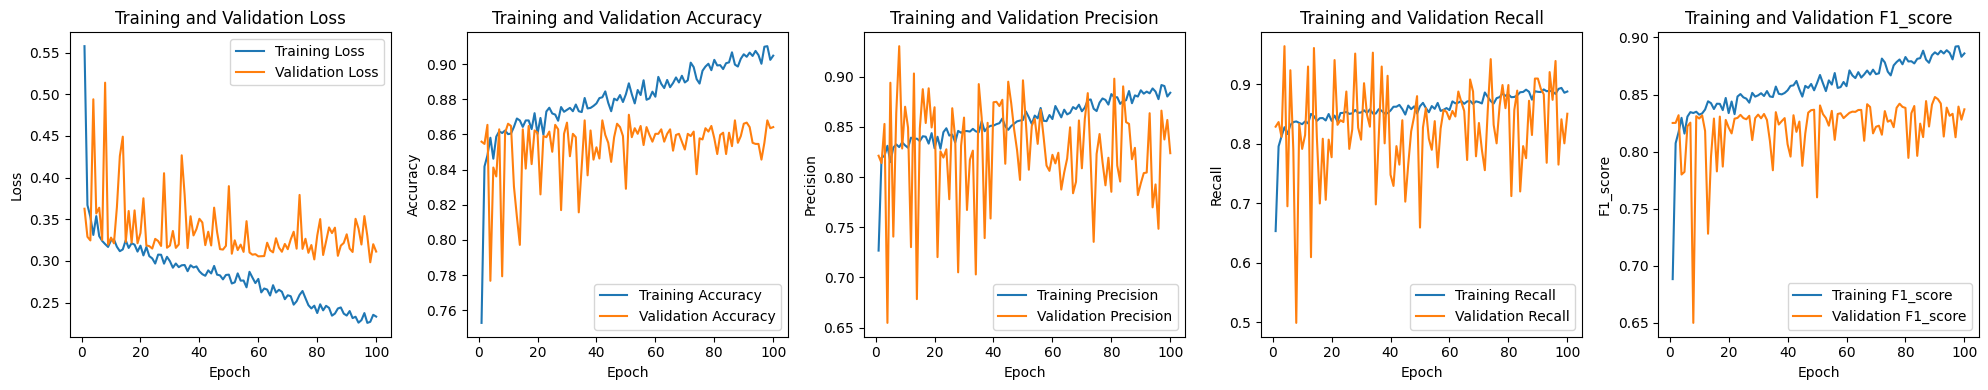

In [116]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_baseline_binary.history.keys() if not key.startswith("val_")]
_, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_baseline_binary.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_baseline_binary.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

Performance on unseen data

In [117]:
baseline_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 0s 3ms/step - loss: 0.3004 - accuracy: 0.8783 - precision: 0.8345 - recall: 0.8673 - f1_score: 0.8506


[0.3004201352596283,
 0.8782828450202942,
 0.8345499038696289,
 0.8672566413879395,
 0.8505889177322388]

ROC Curve and AUC Value

62/62 [==============================] - 0s 3ms/step


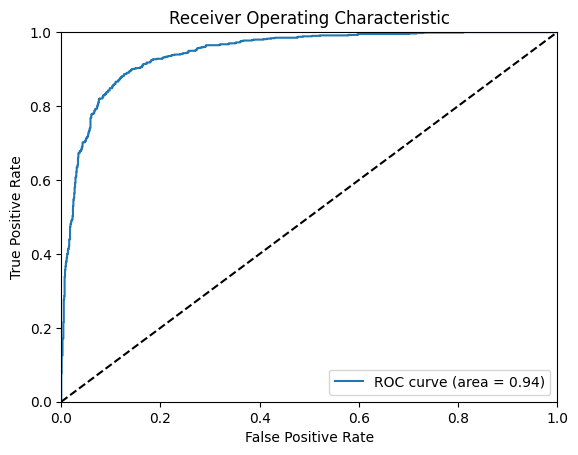

In [118]:
binary_roc_curve(baseline_binary, test_isCancerous_generator)

### Summary of Model Performance
Based on the provided performance metrics, we can analyze the performance of the model as follows:
The binary classification baseline model seems to perform well on the training set, with relatively high accuracy, precision, recall, and F1 score. However, it is important to consider the results on the validation set to see if the binary classification baseline model can generalize well to unseen data.
However, there seems to be a significant gap between the training and validation results, indicating signs of overfitting. The binary classification baseline may have learned the training data too well, making it unable to generalize to new, unseen data.
Additionally, another potential issue is that the recall and precision of the model are very unstable during both training and validation stages. This may indicate difficulties in classifying positive and negative examples, suggesting the need for further optimization to improve its generalization ability and convergence stability.
We also noticed that the validation loss fluctuates and does not show a consistent downward trend, which may again indicate overfitting and a need for adjusting the learning rate in the later stages.
Looking at the ROC curve, the model already exhibits some classification ability, with an AUC value of 0.94, indicating a strong ability to differentiate between positive and negative samples. However, an ideal ROC curve should be closer to the top-left corner, which means the model can maintain a high recall while minimizing the false positive rate. Therefore, although the current model's performance is relatively good, there is still room for improvement.

### Improvement
Here, we will summarize the potential improvements to the baseline model based on all the previous discussions. Firstly, based on the EDA, we identified the issue of data imbalance, and in the data splitting part, we addressed it by assigning class weights to mitigate the impact of the imbalanced dataset. Secondly, based on the performance of our baseline model, we identified that the model is overfitting and fails to demonstrate generalization ability on the validation and unseen test sets. Therefore, we need to address overfitting by improving the model, adding regularization techniques such as dropout layers, and utilizing batch normalization layers, which can enhance the model's generalization ability and accelerate convergence speed. Additionally, we will incorporate image augmentation techniques in the improvement phase, which can increase the diversity of training data and reduce the risk of overfitting. Lastly, we noticed that the baseline model's convergence is not stable, so we will lower the learning rate and dynamically adjust it based on the change in the validation set loss to ensure stable convergence of the model.

## MLP Baseline Model for Multi-class Task
In this task, we need to predict the class of cell images, making it a multi-class classification problem. We will still use a simple MLP model as our baseline model. The main difference from the MLP model for binary classification is the activation function in the output layer, which changes from sigmoid to softmax. Additionally, we will modify our loss function from binary cross-entropy to categorical cross-entropy, as our task has transitioned from binary to multi-class.

### Problem Formulation
For multi-class classification using a multilayer perceptron (MLP), the loss function employed is categorical cross-entropy. The objective function can be expressed as:

$$\min_{h \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^{n} \left(-\sum_{c=1}^{C} y_{ic} \log(h_{ic}(\mathbf{x}_i))\right)$$

Here, $\mathcal{H}$ represents the hypothesis space, which is the set of all possible MLP functions. $h_{ic}(\mathbf{x}_i)$ denotes the predicted value (class $c$) by the MLP for input $\mathbf{x}_i$, and $y_{ic}$ corresponds to the one-hot encoding of the true label (value for class $c$).

Similar to the explanation given earlier, the hypothesis space $\mathcal{H}$ can be considered as the function space consisting of all possible MLP models with varying parameters, layers, and nodes.

### Model Description
The model structure remains similar to the binary classification baseline model.
Compared to the binary baseline model, we change the activation function in the output layer to softmax to handle multi-class classification.

In [119]:
num_classes = 4
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

### Compiling the Model
For the multi-class task, we will use cross-entropy loss as the loss function for this training. We will continue to use Adam as the optimizer. Additionally, we will record the same metrics as in the binary classification baseline model. Precision, Recall, and F1 Score will be calculated using the weighted approach, which is applicable to multi-class problems.

In [120]:
baseline_categorical.compile(loss='categorical_crossentropy',
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=['accuracy',
                                      MultiPrecision(),
                                      MultiRecall(),
                                      MultiCategoryF1Score(num_category=4)])

### Training the Model

In [121]:
epochs = 100
history_baseline_categorical = baseline_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size
)

Epoch 1/100
197/197 [==============================] - 2s 6ms/step - loss: 1.3156 - accuracy: 0.5317 - precision: 0.4864 - recall: 0.5317 - f1_score: 0.5080 - val_loss: 1.2245 - val_accuracy: 0.4764 - val_precision: 0.4630 - val_recall: 0.4764 - val_f1_score: 0.4696
Epoch 2/100
197/197 [==============================] - 1s 5ms/step - loss: 0.9453 - accuracy: 0.6290 - precision: 0.5928 - recall: 0.6290 - f1_score: 0.6104 - val_loss: 0.9390 - val_accuracy: 0.6409 - val_precision: 0.5737 - val_recall: 0.6409 - val_f1_score: 0.6054
Epoch 3/100
197/197 [==============================] - 1s 4ms/step - loss: 0.8547 - accuracy: 0.6649 - precision: 0.6288 - recall: 0.6649 - f1_score: 0.6463 - val_loss: 0.8272 - val_accuracy: 0.6754 - val_precision: 0.6007 - val_recall: 0.6754 - val_f1_score: 0.6359
Epoch 4/100
197/197 [==============================] - 1s 5ms/step - loss: 0.8462 - accuracy: 0.6668 - precision: 0.6325 - recall: 0.6668 - f1_score: 0.6492 - val_loss: 0.8262 - val_accuracy: 0.6684 

Visualizing the training process

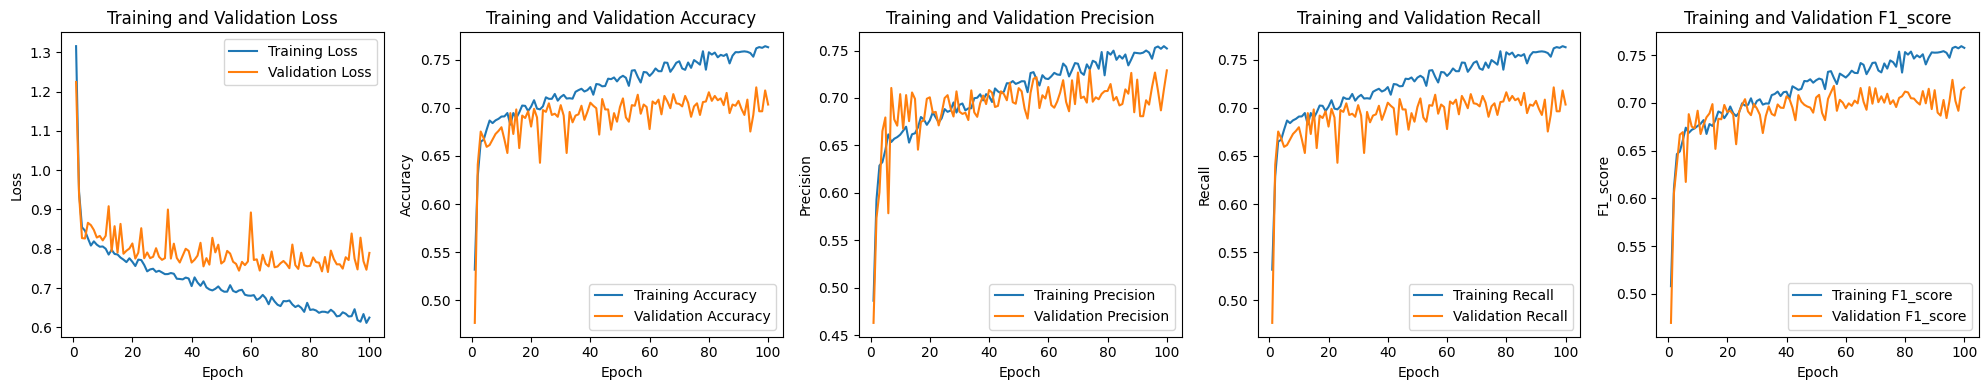

In [122]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_baseline_categorical.history.keys() if not key.startswith("val_")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_baseline_categorical.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_baseline_categorical.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

Performance on unseen data

In [123]:
baseline_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 0s 3ms/step - loss: 0.8358 - accuracy: 0.7091 - precision: 0.7165 - recall: 0.7091 - f1_score: 0.7128


[0.8358175158500671,
 0.7090908885002136,
 0.7164575457572937,
 0.7090908885002136,
 0.7127551436424255]

ROC Curve and AUC Value

62/62 [==============================] - 0s 3ms/step


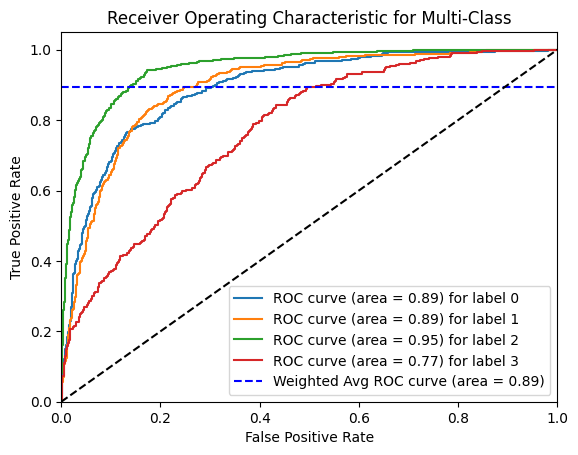

In [124]:
categorical_roc_curve(baseline_categorical, test_cellType_generator)

### Summary of Model Performance
The multi-class baseline model seems to perform poorly on the training set, with relatively low accuracy, precision, recall, and F1 score. The performance on the validation set is even worse.
At the same time, we can observe a significant gap between the training and validation results in the loss curve, indicating signs of overfitting.
Similar to the binary classification baseline model, the validation loss fluctuates and shows a very slow decreasing trend.
From the trend of accuracy, precision, recall, and F1 score, we can see that the model still fails to converge stably in the later stages.
Furthermore, the performance of the model on the unseen test set is also unsatisfactory, with an F1 score of only about 0.71.
Finally, looking at the ROC curve, we can see variations in the model's performance across different classes. Particularly for the last class, the model's AUC value is 0.77, which is relatively low compared to other classes, indicating some difficulties in handling tasks related to this class.
The weighted average AUC of the model is 0.89, which is a good score. However, we also need to note that the model faces challenges in handling tasks related to the fourth class. We will further optimize the model in the improvement phase, especially in handling tasks related to the fourth class, to enhance the overall performance of the model.

### Improvement
The improvement strategies are similar to those for the binary classification model.

---
# Enhanced Model
To improve the model, we will use Convolutional Neural Networks (CNNs). CNNs are a specialized type of neural network primarily used for processing data with a grid-like structure, such as images. The distinguishing feature of CNNs is their hierarchical structure and weight-sharing mechanism. Each layer of a CNN consists of multiple convolutional filters, and each filter learns different features from the input data. This enables CNNs to capture local spatial correlations in the data. By sharing weights, CNNs reduce the number of parameters in the model, which not only reduces computational complexity but also helps prevent overfitting.

## Image Augmentation and Data Generator
As we said before, In order to improve the baseline model's performance and increase its ability to generalize, we introduce image augmentation techniques. These techniques apply random transformations to the images, such as rotation, shifting, shearing, and flipping, which can help the model learn more robust features and reduce overfitting.

To achieve this, we have enhanced the functionality of the existing `ImageDataGenerator` class provided by Keras. Our custom data generator, called `CustomImageDataGenerator`, randomly selects a specified number of augmentations each time an image is processed. By introducing this approach, we introduce more diversity into the training data, thereby enhancing the model's ability to generalize to unseen examples. The number of augmentations chosen has become a hyperparameter that requires tuning. We experimented with different values, including 3, 4, and 5, and observed that using 4 augmentations yielded better generalization compared to using 3. However, increasing the number to 5 did not bring significant improvements over 4.

In the `CustomImageDataGenerator` class, we override the `apply_transform` method. This method randomly selects `num_augmentations` transformations from a list of possible augmentations each time an image is processed.

Next, we instantiate this custom data generator and specify the types of transformations and their ranges. In this case, we allow the images to be rotated, shifted in width and height, sheared, zoomed, brightness adjusted, and flipped horizontally and vertically. The `fill_mode` parameter is set to 'nearest', which fills in any new pixels created by the transformations with their nearest neighbors. So we choose 4 as the hyperparameter for the number of augmentations.

Finally, we create the data generators for training the 'isCancerous' and 'cellType' models. These generators will read the images from the disk and apply the specified augmentations on the fly.
Through the use of this custom image data generator, we aim to increase the diversity of the training data, and thus improve the model's ability to generalize to unseen data.

In [125]:
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

    def apply_transform(self, x, transform_parameters):
        augmentations = [
            "theta",
            "tx",
            "ty",
            "shear",
            "zx",
            "zy",
            "flip_horizontal",
            "flip_vertical",
            "brightness",
        ]

        selected_augmentations = random.sample(augmentations, self.num_augmentations)
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items() if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

train_datagen = CustomImageDataGenerator(
    num_augmentations=4,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 6332 validated image filenames belonging to 2 classes.
Found 6332 validated image filenames belonging to 4 classes.


## Learning Rate Scheduler
As mentioned earlier, to ensure stable convergence in the later stages of training, we employ a callback method called `ReduceLROnPlateau` to dynamically adjust the learning rate. This method monitors the validation loss (`monitor='val_loss'`) and if the validation loss does not improve for consecutive 3 epochs (`patience=3`), the current learning rate is multiplied by a factor (`factor=np.sqrt(0.1)`) to decrease the learning rate. Additionally, this method sets a minimum value for the learning rate (`min_lr=0.5e-15`) to prevent the learning rate from becoming too small. This strategy helps us achieve more stable convergence in the later stages of training because as the training progresses, we require finer steps to optimize the model parameters.

In [126]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)

## Setting Regularization Strength
Currently, I have selected 0.01 as the regularization strength coefficient, indicating that we have introduced a relatively mild regularization. We can also try adjusting other regularization strength coefficients to see their impact on the model's performance.

In [127]:
l2_coeff = 0.01

## Binary Classification Convolutional Neural Network (Enhanced Model)
In this task, we still aim to predict whether a cell image is cancerous or not. I will use Convolutional Neural Networks (CNNs) as our enhanced model. CNNs have been widely adopted for image recognition tasks due to their excellent performance. Unlike the previous baseline model, our CNN model will leverage convolutional layers to capture local features in the image that may be overlooked by fully connected networks.

The enhanced model consists of multiple convolutional layers, max-pooling layers, a fully connected layer, and an output layer. The convolutional layers are responsible for extracting features from the input images, while the max-pooling layers reduce the spatial dimensions of the output from the convolutional layers, reducing model complexity and potential overfitting. The fully connected layer integrates these features, and the output layer provides the predicted probabilities for each class.

To prevent overfitting and improve model performance, we will also employ batch normalization and Dropout. Batch normalization accelerates the convergence speed of the model and acts as a form of regularization. Dropout randomly drops out a portion of neurons during training, enhancing the model's generalization ability.

Additionally, we will incorporate the data augmentation generator we just created to increase sample diversity during model training, further improving the model's generalization ability and performance.

Since the task remains the same, we will continue to use binary cross-entropy as the loss function.

### Problem Formulation
The objective function remains the same as the binary classification baseline model.

However, for the hypothesis space $\mathcal{H}$, we consider $\mathcal{H}$ as the function space consisting of all possible CNN models with varying parameters, layers, kernel sizes, and numbers.

### Model Description
Compared to the baseline model, we have made several changes.

Our binary classification CNN model includes convolutional layers, max-pooling layers, fully connected layers, and Dropout layers. Here's a detailed description of each layer in the model:

The model starts with two Convolutional Blocks. Each Convolutional Block consists of two Conv2D layers, two BatchNormalization layers, and a pooling layer. To enhance the expressive power and generalization performance of the model, we use two convolutions within each Convolutional Block. Batch normalization is inserted between convolutions and between convolution and pooling. The first Convolutional Block uses 32 3x3-sized filters, while the second Convolutional Block uses 64 3x3-sized filters. Due to the use of pooling operations, we apply the `same` padding parameter in the convolutional layers to maintain the same output feature map size as the input feature map.

The model then enters the Flatten layer, which flattens the output tensor from the convolutional layers into a 1D tensor. Next, the model enters the fully connected layers. Our binary classification CNN model includes two fully connected layers, each with 512 neurons and a BatchNormalization layer. A Dropout layer is added after each fully connected layer to mitigate overfitting. Finally, the model outputs a probability value representing the likelihood of the input belonging to the positive class.

We will use `relu` as the activation function throughout the model. L2 regularization will also be applied. It's important to note that the choice of activation function, regularization method, and regularization strength are hyperparameters that can be adjusted.

In [128]:
model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_16 (Ba  (None, 27, 27, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_17 (Ba  (None, 25, 25, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                      

### Compiling the Model
Similar to the binary classification baseline model, but with a difference in the learning rate adjustment. Based on the results of the baseline model, we need to decrease the learning rate to ensure stable convergence.

In [129]:
model_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       F1Score()])

### Training the Model

In [130]:
epochs = 100
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 6s 26ms/step - loss: 13.2418 - accuracy: 0.7956 - precision: 0.7201 - recall: 0.8326 - f1_score: 0.7723 - val_loss: 12.8359 - val_accuracy: 0.4107 - val_precision: 0.4103 - val_recall: 1.0000 - val_f1_score: 0.5819 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 5s 26ms/step - loss: 12.0016 - accuracy: 0.8314 - precision: 0.7691 - recall: 0.8516 - f1_score: 0.8082 - val_loss: 11.2049 - val_accuracy: 0.7666 - val_precision: 0.6418 - val_recall: 0.9751 - val_f1_score: 0.7741 - lr: 1.0000e-04
Epoch 3/100
197/197 [==============================] - 5s 26ms/step - loss: 10.9763 - accuracy: 0.8392 - precision: 0.7793 - recall: 0.8557 - f1_score: 0.8157 - val_loss: 10.0617 - val_accuracy: 0.8724 - val_precision: 0.7865 - val_recall: 0.9456 - val_f1_score: 0.8588 - lr: 1.0000e-04
Epoch 4/100
197/197 [==============================] - 6s 28ms/step - loss: 10.0407 - accuracy: 0.8413 - precision: 0.7826 - recall: 0.8577

Visualizing the training process

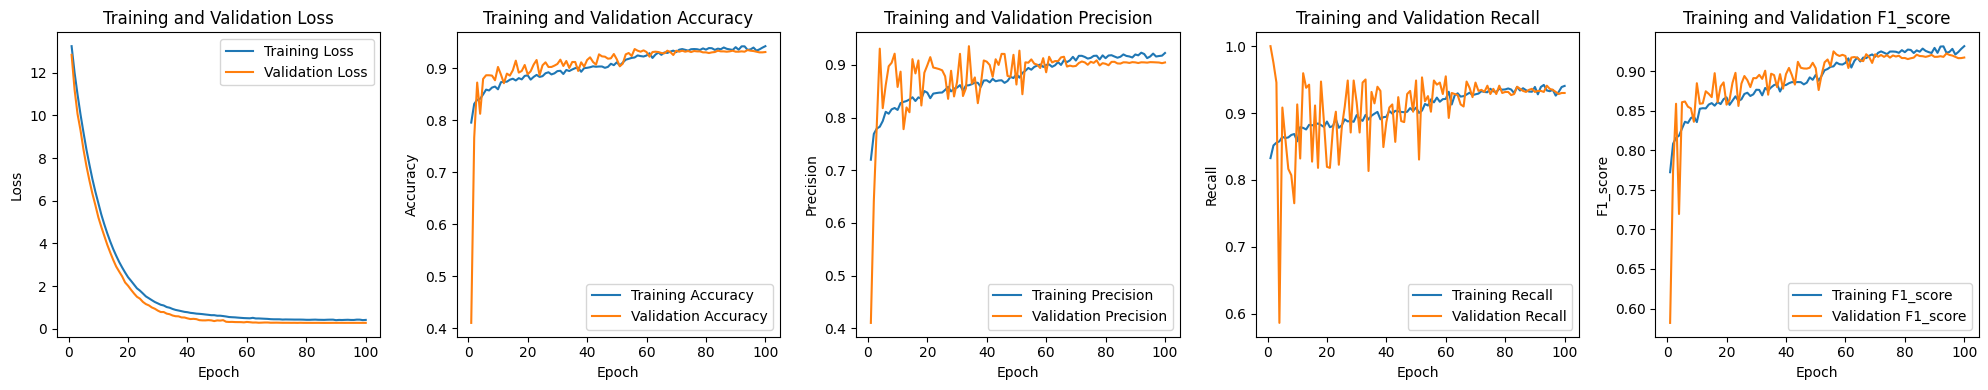

In [131]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_binary.history.keys() if not key.startswith("val_") and not key.startswith("lr")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_binary.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_binary.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

Performance on unseen data

In [132]:
model_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 1s 9ms/step - loss: 0.2815 - accuracy: 0.9323 - precision: 0.9081 - recall: 0.9241 - f1_score: 0.9160


[0.28153297305107117,
 0.9323232173919678,
 0.9080745577812195,
 0.9241466522216797,
 0.9160400032997131]

ROC Curve and AUC Value

62/62 [==============================] - 1s 9ms/step


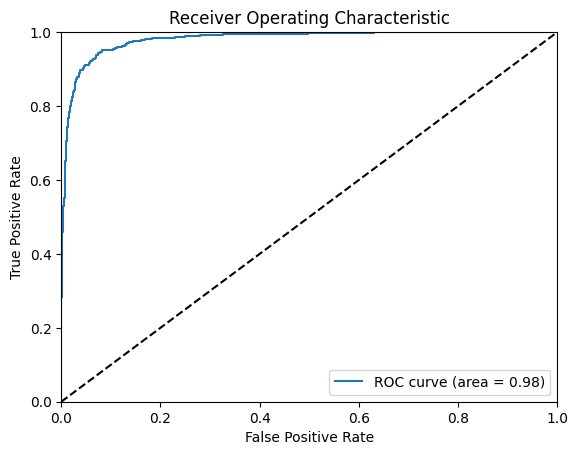

In [133]:
binary_roc_curve(model_binary, test_isCancerous_generator)

### Summary of Model Performance
Based on the training process curves, we can observe that the convergence of the model is much more stable compared to the binary classification baseline model, as seen in the curve of the loss function. Although the convergence of recall may not be stable in the early stages, it stabilizes in the later stages, and other metrics also demonstrate stable convergence. Additionally, there is minimal gap between the validation set and training set, indicating that the model maintains good generalization while ensuring performance. Furthermore, the model achieves high scores on the unseen test set, with an accuracy of approximately 0.94, precision of approximately 0.91, recall of approximately 0.93, and F1 score of approximately 0.92. This indicates that the model performs exceptionally well in distinguishing between cancerous and non-cancerous images. The high recall value suggests that the model can effectively identify true positive cases, which is crucial for cancer detection. Moreover, the ROC curve is close to the upper left corner, indicating that the model exhibits high sensitivity and specificity in the classification task, with an AUC value of 0.98, signifying a high probability of correct classification for any given image. Overall, compared to the baseline model, this binary classification CNN model demonstrates significant improvement in this task, leveraging spatial information in the images and reducing the risk of misdiagnosis and missed diagnoses.

## Multi-class Convolutional Neural Network (Enhanced Model)
In this task, our goal remains to predict the classification of cell images. We will continue to use Convolutional Neural Networks (CNNs) as our enhanced model.

As mentioned in the enhanced model for binary classification, techniques such as regularization and dropout layers are employed to prevent overfitting.

Since this is a multi-class task, we will use the categorical cross-entropy function as our loss function.

### Problem Formulation
The objective function remains the same as the multi-class baseline model.

However, for the hypothesis space $\mathcal{H}$, we consider $\mathcal{H}$ as the function space consisting of all possible CNN models with varying parameters, layers, kernel sizes, and numbers.

### Model Description
The structure of the multi-class CNN model is almost identical to the binary classification CNN model. However, as mentioned earlier, the number of layers and the number of perceptrons are hyperparameters that we need to adjust. Based on our experiments, we found that removing two batch normalization layers from the fully connected layers in the CNN multi-class model leads to more stable convergence and slightly better performance on unseen test data. Additionally, since this task is a multi-class classification, we change the activation function in the final output layer from sigmoid to softmax and set the number of classes to 4.

In [134]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_22 (Ba  (None, 27, 27, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_23 (Ba  (None, 25, 25, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                     

### Compiling the Model

In [135]:
model_categorical.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                          metrics=['accuracy',
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall'),
                                   MultiCategoryF1Score()])

### Training the Model

In [136]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 5s 25ms/step - loss: 16.8487 - accuracy: 0.5573 - precision: 0.6274 - recall: 0.4486 - f1_score: 0.5722 - val_loss: 13.3772 - val_accuracy: 0.2608 - val_precision: 0.2562 - val_recall: 0.2449 - val_f1_score: 0.3125 - lr: 3.0000e-04
Epoch 2/100
197/197 [==============================] - 5s 24ms/step - loss: 14.4689 - accuracy: 0.6229 - precision: 0.7228 - recall: 0.5067 - f1_score: 0.6318 - val_loss: 10.8444 - val_accuracy: 0.5631 - val_precision: 0.6436 - val_recall: 0.4930 - val_f1_score: 0.5812 - lr: 3.0000e-04
Epoch 3/100
197/197 [==============================] - 5s 24ms/step - loss: 12.6988 - accuracy: 0.6446 - precision: 0.7289 - recall: 0.5308 - f1_score: 0.6539 - val_loss: 8.9647 - val_accuracy: 0.7283 - val_precision: 0.8241 - val_recall: 0.6186 - val_f1_score: 0.7336 - lr: 3.0000e-04
Epoch 4/100
197/197 [==============================] - 5s 24ms/step - loss: 11.1568 - accuracy: 0.6649 - precision: 0.7564 - recall: 0.5535 

Visualizing the training process

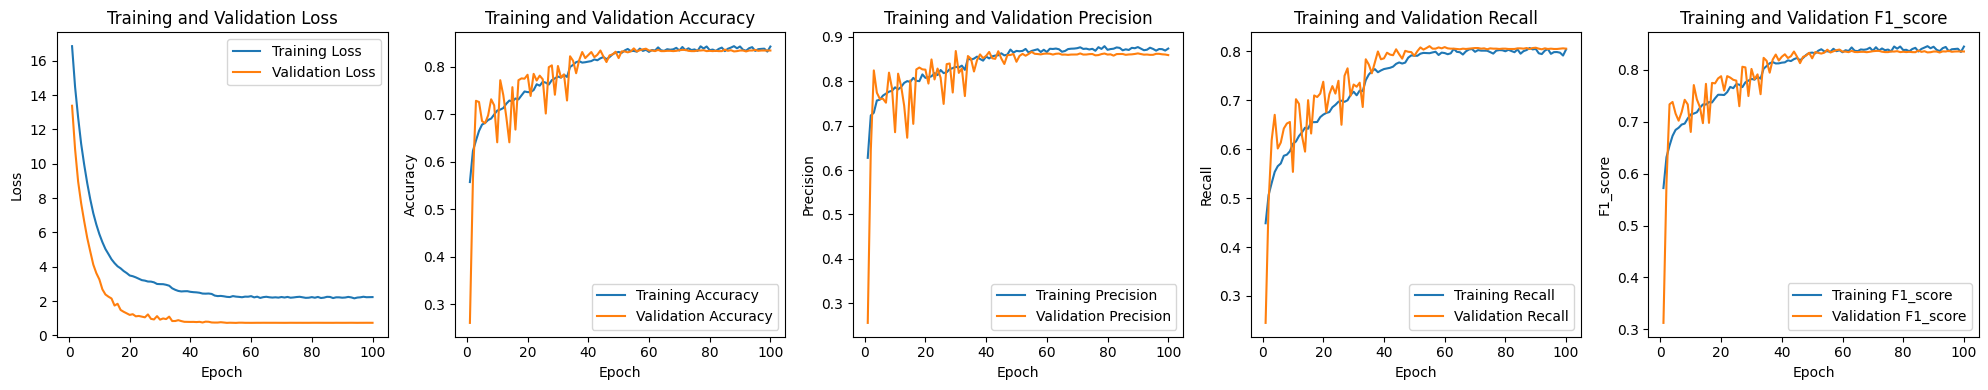

In [137]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_categorical.history.keys() if not key.startswith("val_") and not key.startswith("lr")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_categorical.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_categorical.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

Performance on unseen data

In [138]:
model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 1s 9ms/step - loss: 0.7883 - accuracy: 0.8066 - precision: 0.8397 - recall: 0.7833 - f1_score: 0.8087


[0.7882775068283081,
 0.8065656423568726,
 0.8397400975227356,
 0.7833333611488342,
 0.808659017086029]

ROC Curve and AUC Value

62/62 [==============================] - 1s 9ms/step


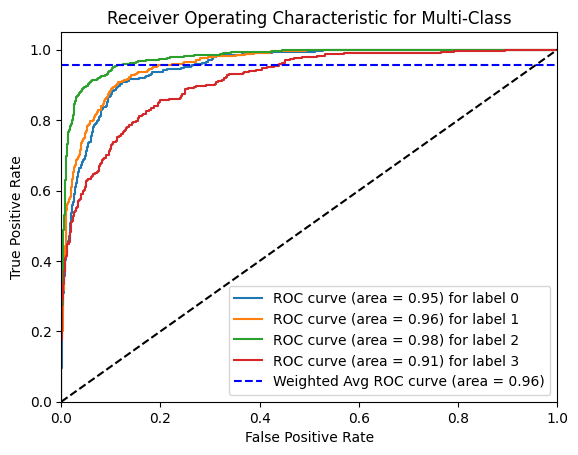

In [139]:
categorical_roc_curve(model_categorical, test_cellType_generator)

### Summary of Model Performance
Observing the training process curves, we can see that the improved CNN multi-classification model demonstrates significant stability. While there was some noticeable fluctuation before 50 epochs, all training curves became stable after that point. It's worth noting that there is a larger gap between the loss of the validation set and the training set, which is due to the weighting assigned. During training, these weights amplify the loss values for certain classes, allowing the model to better learn those classes. Furthermore, from the curves and scores of the training process, as well as the performance on the training and validation sets, we can observe that the model exhibits minimal performance gap between the two sets, indicating good generalization ability.

On the unseen test set, the model achieves high scores with an accuracy and F1 score of approximately 0.82, precision of approximately 0.84, and recall of approximately 0.8. These high scores demonstrate that the model performs exceptionally well in distinguishing between multiple classes of images. The model also demonstrates strong classification ability for each class, with AUC values of 0.95, 0.96, 0.98, and 0.91 for each respective class, and a weighted average AUC of 0.96. Particularly noteworthy is the model's ROC curves, which are close to the upper left corner, indicating high sensitivity and specificity in the classification task. Compared to the multi-class baseline model, there is an improvement in the AUC values for each class, especially for the last class, which increases from 0.77 to 0.91. This significant improvement indicates the enhanced multi-classification model's ability to recognize different classes, particularly in identifying the last class.

In summary, the improved multi-classification model demonstrates significant performance improvement compared to the baseline model in this task.

In [140]:
model_categorical.load_weights('saved_model/model_categorical_weights')

# Enhanced Multi-class Convolutional Neural Network (DI/HD Part)
According to the task requirements, we need to enhance the multi-class model using the `data_labels_extraData.csv` file. First, let's load this dataset and examine its characteristics. We can see that the dataset contains the `isCancerous` label, but there is no `cellType` column. Therefore, we don't have the corresponding multi-class labels. Now we have one dataset with multi-class labels and another dataset without multi-class labels. Hence, semi-supervised learning becomes a natural choice. Semi-supervised learning is a machine learning approach that leverages both labeled data and unlabeled data for training.

The main idea of semi-supervised learning is to utilize the distribution information of the unlabeled data to assist the classification decisions of labeled data, thereby improving the model's performance. Specifically, it assumes that the decision boundaries between classes should pass through regions with low data density, or in other words, similar data samples should have the same or similar output labels.

In our problem, we can utilize the improved multi-class model trained on labeled data and then use this model to make predictions on the dataset without multi-class labels, obtaining predicted labels. Then, we can treat these predicted labels as new labels and combine them with the original labels for training the model again. Through this iterative process, we can gradually improve the model's prediction accuracy on the unlabeled data, thereby enhancing the overall model performance.

We will employ a semi-supervised learning algorithm called FixMatch ([Sohn, 2020](https://arxiv.org/abs/2001.07685)) to accomplish our task.

In [141]:
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra.info()
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB


## FixMatch Implementation
FixMatch is a semi-supervised learning algorithm proposed by the Google Brain team in 2020, and it has demonstrated excellent performance in various image recognition benchmarks. The main characteristics of FixMatch are its simplicity and effectiveness, successfully integrating some key principles of semi-supervised learning into a framework that is easy to understand and implement.

The workflow of FixMatch can be summarized into the following steps:
- First, apply a series of mild augmentations (such as random cropping and horizontal flipping) to the input images to generate weakly augmented versions.
- Second, use the current trained model to make predictions on the weakly augmented images, generating pseudo-labels.
- Third, apply a series of more aggressive augmentations (such as changes in color, contrast, and brightness) to the same input images to generate strongly augmented versions. The authors of FixMatch employ techniques such as Cutout ([DeVries](https://arxiv.org/abs/1708.04552)), CTAugment ([Berthelot](https://arxiv.org/abs/1911.09785)), and RandAugment ([Cubuk](https://arxiv.org/abs/1909.13719)) for highly aggressive image augmentation.
- Fourth, calculate the consistency loss. The model is trained to produce consistent predictions on both the weakly augmented and strongly augmented images. This is typically achieved by minimizing the discrepancy between the predictions, computed using cross-entropy loss.
- Fifth, FixMatch introduces a probability threshold, where pseudo-labels are only used for training if the model's prediction on the weakly augmented image surpasses a certain probability threshold. This step helps prevent the model from relying too heavily on erroneous pseudo-labels.
- Finally, the model's final loss function is a combination of supervised loss (i.e., the model's performance on labeled images) and unsupervised loss (i.e., the consistency on weakly augmented and strongly augmented images). In this way, the model can leverage both labeled and unlabeled data simultaneously. The goal of FixMatch is to minimize the discrepancy between the model's predictions on weakly augmented and strongly augmented images while minimizing the prediction error on labeled images. This design enables FixMatch to effectively utilize unlabeled data, enhance the model's generalization capability, and reduce the risk of overfitting.

### Data Generator
As mentioned earlier, FixMatch introduces special image augmentation techniques, such as RandAugment. Therefore, to implement FixMatch reliably and effectively, we encapsulate the RandAugment method implemented in the imgaug library into an `ImageDataGenerator` to generate specially augmented image data. This allows us to meet the requirements of FixMatch while leveraging all the advantages of the `ImageDataGenerator`.

In [142]:
class RandAugmentGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, n, m, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rand_aug = iaa.RandAugment(n=n, m=m)

    def apply_transform(self, x, transform_parameters):
        x = tf.cast(x, tf.uint8)
        x_aug = self.rand_aug(image=x.numpy())
        x_aug = tf.cast(x_aug, tf.float64)
        return super().apply_transform(x_aug, transform_parameters)

### Image Augmentation
The following code snippet bears some similarity to the image augmentation method we created earlier for the enhanced model. However, the difference lies in the fact that here we augment the extra dataset to meet the specific requirements of weakly augmented and strongly augmented images in the FixMatch algorithm. For weak augmentation, we perform mild transformations such as horizontal flipping and vertical flipping, and scale the pixel values to the range of [0, 1]. For strongly augmented images, we use the previously encapsulated `RandAugmentGenerator` class to augment the images.

Additionally, we want all samples from the extra dataset to be processed by the model within one training epoch. Therefore, we need to calculate the batch size for the extra dataset accordingly. To compute the batch size for the extra dataset, we divide the total number of samples in the extra dataset by the total number of samples in the training dataset and then multiply by the original batch size. This calculation ensures that all samples from the extra dataset are processed by the model in each training epoch, thereby improving the learning efficiency and performance of the model.

In [143]:
unlabeled_batch_size = len(data_extra) // len(train_data) * batch_size
unlabeled_datagen_weak = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

unlabeled_generator_weak = unlabeled_datagen_weak.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=unlabeled_batch_size,
    class_mode='binary',
    shuffle=False
)

unlabeled_datagen_strong = RandAugmentGenerator(
    n=4, m=6,
    rescale=1./255,
    fill_mode='nearest'
)

unlabeled_generator_strong = unlabeled_datagen_strong.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=unlabeled_batch_size,
    class_mode='binary',
    shuffle=False
)

Found 10384 validated image filenames belonging to 2 classes.
Found 10384 validated image filenames belonging to 2 classes.


### Problem Formulation
For the FixMatch approach we are using, the loss function consists of two parts: supervised loss $\ell_s$ and unsupervised loss $\ell_u$. Therefore, our objective function can be formulated as follows:

$$\min_{h \in \mathcal{H}} \ell_s(h; \mathbf{x}_l, y_l) + \lambda \cdot \ell_u(h; \mathbf{x}_u)$$

Here, $\mathcal{H}$ is the hypothesis space, which is the set of all possible neural network models. $h$ represents a specific model; $(\mathbf{x}_l, y_l)$ and $\mathbf{x}_u$ represent the labeled input data, labeled output data, and unlabeled input data, respectively; $\lambda$ is a hyperparameter that balances the importance of different losses.

- The supervised loss $\ell_s(h; \mathbf{x}_l, y_l)$ is the supervised loss of the model $h$ on the labeled data $(\mathbf{x}_l, y_l)$.

$$\ell_s=\frac{1}{B} \sum_{b=1}^B \mathrm{H}\left(p_b, p_{\mathrm{m}}\left(y \mid \alpha\left(x_b\right)\right)\right)$$

Here, $B$ is the batch size, $p_b$ is the predicted probability distribution of the model $h$ for the input $x_b$, $p_{\mathrm{m}}$ is the probability distribution of the true label $y$, $\alpha$ is the data augmentation function, and $\mathrm{H}$ is the cross-entropy loss.

- The unsupervised loss $\ell_u(h; \mathbf{x}_u)$ is the unsupervised loss of the model $h$ on the unlabeled data $\mathbf{x}_u$, where the pseudo-labels of $\mathbf{x}_u$ are generated by the model $h$ itself.

$$\ell_{u}=\frac{1}{B} \sum_{b=1}^{B} \mathbb{1}\left(\max \left(\hat{p}_b\right) \geq \tau\right) \mathrm{H}\left(\hat{p}_b, p_{\mathrm{m}}\left(y \mid \mathcal{A}\left(u_b\right)\right)\right)$$

Here, $\hat{p}_b$ is the predicted probability distribution of the model $h$ for the weakly-augmented version of the input $u_b$. The pseudo-labels are derived from this distribution, provided that the maximum value in $\hat{p}_b$ is greater than or equal to the confidence threshold $\tau$. $\mathcal{A}$ is a stronger data augmentation function applied to the unlabeled data $u_b$ to generate a more complex version of the input. The unsupervised loss for an unlabeled sample is only computed if the model's predicted probability for a certain class on the weakly-augmented version of the input is greater than $\tau$.

By optimizing this objective function, we can perform supervised learning on labeled data and self-supervised learning on unlabeled data, fully utilizing the data to improve the model's performance.

In [144]:
def apply_fixmatch(x, y_true, x_unlabeled, model, optimizer, training=True, class_weight_dict=None, consistency_weight=1, confidence_threshold=0.95):
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x)
        # Compute the supervised loss
        # If training and class weights are given, calculate the loss based on the weights.
        if class_weight_dict is not None and training:
            class_weight_tensor = tf.constant([class_weight_dict[0], class_weight_dict[1], class_weight_dict[2], class_weight_dict[3]])
            sample_weights = tf.gather(class_weight_tensor, tf.argmax(y_true, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled))
        final_loss = supervised_loss

        # Calculate the output of the model on the original unlabeled data and the augmented unlabeled data
        if x_unlabeled is not None:
            # Perform data augmentation on unlabeled data
            y_pred_unlabeled_weak = model(x_unlabeled[0])
            y_pred_unlabeled_strong = model(x_unlabeled[1])
            # Compute pseudo labels
            pseudo_labels = tf.argmax(y_pred_unlabeled_weak, axis=-1)
            # Calculate the maximum probability
            max_probs = tf.reduce_max(y_pred_unlabeled_weak, axis=-1)
            # Confidence-based masking Confidence-based masking
            mask = max_probs > confidence_threshold
            # Compute consistency loss
            pseudo_labels_one_hot = tf.one_hot(pseudo_labels, depth=tf.shape(y_pred_unlabeled_weak)[-1])
            per_example_loss = tf.keras.losses.categorical_crossentropy(pseudo_labels_one_hot, y_pred_unlabeled_strong)
            consistency_loss = tf.reduce_sum(per_example_loss * tf.cast(mask, per_example_loss.dtype)) / tf.reduce_sum(tf.cast(mask, tf.float32) + tf.keras.backend.epsilon())

            final_loss = final_loss + consistency_weight * consistency_loss

        # Calculate accuracy
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        accuracy.update_state(y_true, y_pred_labeled)

        if training:
            # Backpropagation and optimization
            grads = tape.gradient(final_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))

    return {"loss": final_loss,
            "supervised_loss": supervised_loss,
            "consistency_loss" :consistency_loss if x_unlabeled is not None else None,
            "accuracy": accuracy.result()}

### Training the Model
Since our model has been pre-trained earlier, to avoid disrupting the useful patterns learned, we choose a smaller learning rate and epochs for fine-tuning. Additionally, we incorporate a learning rate adjustment strategy where the learning rate is reduced when the model's performance on the validation set does not significantly improve. This helps to stimulate the learning process of the model and search for better solutions, which is different from our previous learning rate decay strategy. In each training epoch, we train and optimize the model by computing the supervised loss on labeled data and the consistency loss on unlabeled data. After training, we evaluate the model's performance on the validation set to assess its generalization capability. This way, we can leverage both labeled and unlabeled data within the framework of semi-supervised learning and improve the model's performance.

In [145]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-8)
epochs = 3
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = adam.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": [], "precision":[],
           "recall":[], "f1":[], "val_precision":[], "val_recall":[], "val_f1":[]}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_category_2_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled_weak, _), (x_unlabeled_strong, _) in zip(train_cellType_generator, unlabeled_generator_weak, unlabeled_generator_strong):
            progress_bar.update(1)
            result = apply_fixmatch(x_batch, y_batch, (x_unlabeled_weak, x_unlabeled_strong),
                                    model_categorical, adam,
                                    class_weight_dict=class_weight_dict_cellType,
                                    confidence_threshold=0.95)
            total_loss += result["loss"]
            total_supervised_loss += result["supervised_loss"]
            total_consistency_loss += result["consistency_loss"]
            total_accuracy += result["accuracy"]
            steps += 1
            # Check if all batches have been processed
            if steps * batch_size >= len(train_data):
                break

        # Calculate and print average loss and accuracy
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps

        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_precision = 0
    total_f1_score = 0
    steps = 0
    for x_batch, y_batch in val_cellType_generator:
        result = apply_fixmatch(x_batch, y_batch, None, model_categorical, adam, training=False)
        total_loss += result["loss"]
        total_accuracy += result["accuracy"]
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps

    history["val_loss"].append(avg_loss)
    history["val_accuracy"].append(avg_accuracy.numpy())

    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}， lr: {current_learning_rate:.2e}")

    # Check if the learning rate needs to be updated
    if avg_loss < min_val_loss:
        min_val_loss = avg_loss
        num_epochs_no_improvement = 0
    else:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        adam.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/3


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.73it/s]


 - loss: 5.8526, supervised_loss: 1.8148, consistency_loss: 4.0378, accuracy: 0.8487
Validation set： - loss: 0.4685, accuracy: 0.8256， lr: 3.00e-08
Epoch 2/3


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:29<00:00,  6.73it/s]


 - loss: 5.2275, supervised_loss: 1.8082, consistency_loss: 3.4194, accuracy: 0.8518
Validation set： - loss: 0.4598, accuracy: 0.8342， lr: 3.00e-08
Epoch 3/3


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:28<00:00,  6.88it/s]


 - loss: 5.7526, supervised_loss: 1.7996, consistency_loss: 3.9530, accuracy: 0.8495
Validation set： - loss: 0.4619, accuracy: 0.8301， lr: 3.00e-08


Performance on unseen data

In [146]:
model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 1s 9ms/step - loss: 0.7829 - accuracy: 0.8177 - precision: 0.8423 - recall: 0.7929 - f1_score: 0.8182


[0.7829282879829407,
 0.8176767826080322,
 0.8422746658325195,
 0.7929292917251587,
 0.8181795477867126]

ROC Curve and AUC Value

62/62 [==============================] - 1s 8ms/step


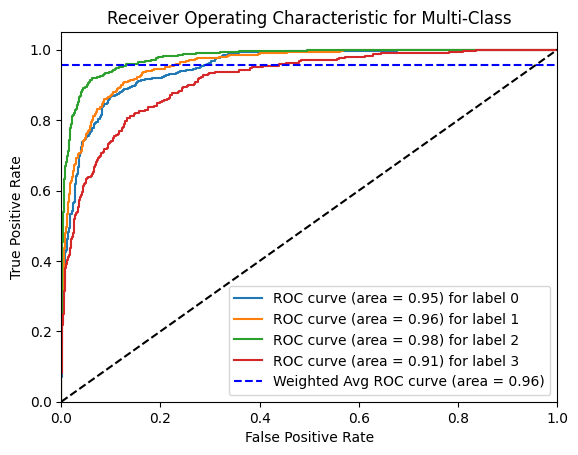

In [147]:
categorical_roc_curve(model_categorical, test_cellType_generator)

### Summary of Model Performance
Based on the training and evaluation results, the improved CNN multi-classification model shows slight performance improvement after optimization using the FixMatch strategy. Specifically, there is a slight decrease in the model's loss and slight improvement in other metrics.

Although the changes in the model's metrics and ROC are not significant, this could be because the model is already performing close to the ideal performance, and there is limited room for further improvement. However, it's important to recognize that all models have an upper limit to their performance. While we can attempt to improve performance through strategies such as increasing the dataset or fine-tuning optimization, these efforts may yield diminishing marginal returns, where the resources and efforts invested may result in smaller performance gains.

Overall, through the use of the FixMatch strategy, we have successfully improved the performance of the CNN multi-classification model, further enhancing its ability to handle image classification tasks.